In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import backend as K
from myModel.model import VGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [2]:
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", # --dataset : The path to our dataset. add required=True if you want
	help="path to input dataset (i.e., directory of images)")
ap.add_argument("-m", "--model", # --model : The path to our output serialized Keras model.
	help="path to output model")
ap.add_argument("-l", "--labelbin", # --labelbin : The path to our output multi-label binarizer object.
	help="path to output label binarizer")
ap.add_argument("-p", "--plot", type=str, default="plot.png", # --plot : The path to our output plot of training loss and accuracy.
	help="path to output accuracy/loss plot")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] [-d DATASET] [-m MODEL] [-l LABELBIN]
                             [-p PLOT]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Outhm\AppData\Roaming\jupyter\runtime\kernel-2fc6180d-f4c5-4c09-b4d4-fb1e44c5af67.json


SystemExit: 2

In [3]:
img_dim = (45,45,3)
EPOCHS = 12
train_data_dir = 'splited_dataset/train'
test_data_dir = 'splited_dataset/test'
BS = 100
LR = 1e-3
labels = []
train_samples_nbr = file_count = sum(len(files) for _, _, files in os.walk(r'splited_dataset/train'))
test_samples_nbr = file_count = sum(len(files) for _, _, files in os.walk(r'splited_dataset/test'))

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (img_dim[2], img_dim[0], img_dim[1])
else:
    input_shape = (img_dim[0], img_dim[1], img_dim[2])

In [6]:
print("[INFO] loading images...")
#imagePaths = sorted(list(paths.list_images(args["dataset"])))
imagePaths = sorted(list(paths.list_images(train_data_dir)))
#imagePaths = sorted(list(paths.list_images("data/extracted_images")))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [7]:
l = label = [ item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item)) ]
labels.append(l)
print("Classes : ",labels[0]) #labels

Classes :  ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'alpha', 'ascii_124', 'b', 'beta', 'C', 'cos', 'd', 'Delta', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'G', 'gamma', 'geq', 'gt', 'H', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'M', 'mu', 'N', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'R', 'rightarrow', 'S', 'sigma', 'sin', 'sqrt', 'sum', 'T', 'tan', 'theta', 'times', 'u', 'v', 'w', 'X', 'y', 'z', '[', ']', '{', '}']


In [10]:
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

[INFO] class labels:


In [11]:
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))

1. !
2. (
3. )
4. +
5. ,
6. -
7. 0
8. 1
9. 2
10. 3
11. 4
12. 5
13. 6
14. 7
15. 8
16. 9
17. =
18. A
19. C
20. Delta
21. G
22. H
23. M
24. N
25. R
26. S
27. T
28. X
29. [
30. ]
31. alpha
32. ascii_124
33. b
34. beta
35. cos
36. d
37. div
38. e
39. exists
40. f
41. forall
42. forward_slash
43. gamma
44. geq
45. gt
46. i
47. in
48. infty
49. int
50. j
51. k
52. l
53. lambda
54. ldots
55. leq
56. lim
57. log
58. lt
59. mu
60. neq
61. o
62. p
63. phi
64. pi
65. pm
66. prime
67. q
68. rightarrow
69. sigma
70. sin
71. sqrt
72. sum
73. tan
74. theta
75. times
76. u
77. v
78. w
79. y
80. z
81. {
82. }


In [12]:
print("[INFO] compiling model...")
model = VGGNet.build(
	width=img_dim[1], height=img_dim[0],
	depth=img_dim[2], classes=82,
    activFct="softmax") #for multi-class classification

[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
opt = Adam(lr=LR, decay=LR / EPOCHS)
#opt = RMSprop(lr=LR, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) #binary_crossentropy training 99% acc 

In [14]:
model

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.0,
    zoom_range=0.0,
    featurewise_center=False,# set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0.0,  # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.0,  # randomly shift images horizontally
    height_shift_range=0.0,  # randomly shift images vertically
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
    )

In [17]:
test_datagen = ImageDataGenerator(rescale=1. / 255)


In [18]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_dim[0], img_dim[1]),
    batch_size=BS,
    class_mode='categorical')

Found 300779 images belonging to 82 classes.


In [19]:
validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_dim[0], img_dim[1]),
    batch_size=BS,
    class_mode='categorical')

Found 75194 images belonging to 82 classes.


In [20]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples_nbr // BS,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=test_samples_nbr // BS)

Instructions for updating:
Use tf.cast instead.
Epoch 1/12
3007/3007 [==============================] - 3063s 1s/step - loss: 1.4073 - acc: 0.6361 - val_loss: 0.5758 - val_acc: 0.8387
Epoch 2/12
3007/3007 [==============================] - 2751s 915ms/step - loss: 0.8477 - acc: 0.7631 - val_loss: 0.4555 - val_acc: 0.8681
Epoch 3/12
3007/3007 [==============================] - 2715s 903ms/step - loss: 0.7306 - acc: 0.7929 - val_loss: 0.4007 - val_acc: 0.8829
Epoch 4/12
3007/3007 [==============================] - 2801s 932ms/step - loss: 0.6685 - acc: 0.8082 - val_loss: 0.3692 - val_acc: 0.8911
Epoch 5/12
3007/3007 [==============================] - 2837s 943ms/step - loss: 0.6224 - acc: 0.8191 - val_loss: 0.3485 - val_acc: 0.8972
Epoch 6/12
3007/3007 [==============================] - 2779s 924ms/step - loss: 0.5962 - acc: 0.8260 - val_loss: 0.3322 - val_acc: 0.9012
Epoch 7/12
3007/3007 [==============================] - 2689s 894ms/step - loss: 0.5700 - acc: 0.8315 - val_loss: 0.3252 

C:\Users\Outhm\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107169). Check your callbacks.
  % delta_t_median)


C:\Users\Outhm\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170129). Check your callbacks.
  % delta_t_median)
C:\Users\Outhm\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123008). Check your callbacks.
  % delta_t_median)


C:\Users\Outhm\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119341). Check your callbacks.
  % delta_t_median)


In [21]:
print("[INFO] serializing network...")
#model.save(args["model"])
model.save("trained_model_final.model")
model.save_weights("weights_final.h5")
#save the multi-label binarizer to disk
print("[INFO] serializing label binarizer...")
# f = open(args["labelbin"], "wb")
f = open("mlb.pickle", "wb")
f.write(pickle.dumps(mlb))
f.close()

[INFO] serializing network...
[INFO] serializing label binarizer...


In [22]:
model.summary();


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        4128      
_________________________________________________________________
activation_2 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          8256      
__________

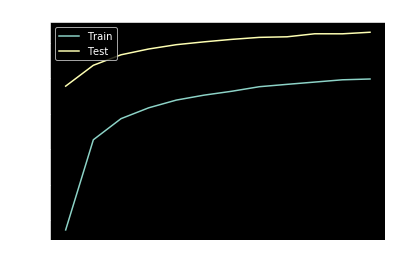

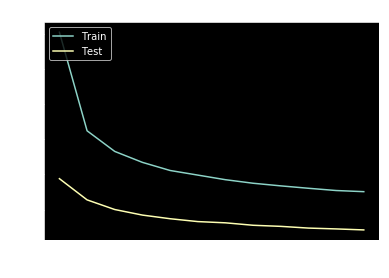

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [44]:
scores = model.evaluate_generator(validation_generator,test_samples_nbr//BS,verbose=1) 

751/751 [==============================] - 180s 239ms/step


In [45]:
print("Accuracy = ", scores[1])


Accuracy =  0.9130290056997683
